# Assginment 7

Hasan AlJamea - 202012499




## Utility functions

In [1]:
from typing import List, Tuple

# !pip install sympy numpy pandas matplotlib seaborn -q
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from IPython.core.display import Math, Markdown

def display_grid(grid: np.ndarray, title:str='')->None:
    plt.figure(figsize=(8, 8))
    heatmap = sns.heatmap(grid,
                      annot=True,  # Add annotations
                      fmt=".2f",   # Format annotations to 2 decimal places
                      cmap="Reds",  # Color map
                      linewidths=.5,  # Add lines between cells
                      cbar_kws={'label': 'Values'})  # Customize colorbar
    heatmap.set_title(title)
    heatmap.set_xlabel('x')
    heatmap.set_ylabel('y')
    heatmap.invert_yaxis()
    plt.tight_layout()
    plt.show()

def display_grid_str(grid):
    return '\n'.join('\t'.join(str(cell) for cell in row) for row in grid[::-1])

def relative_error(*,old_values: pd.Series, new_values: pd.Series) -> float:
    if not old_values[old_values==0].empty:
        return 100
    diff = old_values - new_values
    rel_error = diff.abs() * 100 / old_values.abs()
    return round(rel_error.max(), 3)

def liebmann(
        t_init:pd.Series,    # initial condition
        df_eqs:pd.Series,    # linear equations
        lambda_r:float=1 ,   # relaxation factor
        relative_error_threshold:float=1,
        max_iterations:int=50,
)->pd.DataFrame:
    t_old = t_init.copy()
    iterations = pd.DataFrame(columns=list(t_init.index) + ['rel_error'])
    iterations.loc[0] = pd.Series({**t_old.to_dict(), 'rel_error': 100})
    for it in range(1,max_iterations+1):
        # calculate formulas
        t_calculated = df_eqs.apply(lambda _: _.subs(t_old.copy().to_dict()).evalf())
        # apply relaxation factor
        t_new = lambda_r * t_calculated + (1- lambda_r) * t_old
        rel = relative_error(old_values=t_old,new_values=t_new)
        iterations.loc[it] = pd.Series({**t_new.to_dict(), 'rel_error': rel})
        if rel < relative_error_threshold:
            break
        t_old = t_new
    return iterations


def heat_flux_2d(
        grid:np.ndarray,
        kp:float,
        dx:float,
        upper_boundary:List[float]=None,
        left_boundary:List[float]=None,
        right_boundary:List[float]=None,
        bottom_boundary:List[float]=None,
)->dict[str,np.ndarray]:
    qx = np.zeros_like(grid)
    qy = np.zeros_like(grid)
    q = np.zeros_like(grid)
    theta = np.zeros_like(grid)
    m,n = grid.shape
    for i,j in product(range(1,grid.shape[0]-1), repeat=2):
        t_up = grid[i+1,j] if i<m-2 else (upper_boundary[j] or grid[m-2,j])
        t_down = grid[i-1,j] if i>0 else (bottom_boundary[j] or grid[1,j])
        t_left = grid[i,j-1] if j>0 else (left_boundary[i] or grid[i,1])
        t_right = grid[i,j+1] if j<n-2 else (right_boundary[i] or grid[i,n-2])

        qx[i,j] = -kp * (t_up - t_down) / dx
        qy[i,j] = -kp * (t_right - t_left) / dx

        q[i,j] = np.sqrt(qx[i,j]**2 + qy[i,j]**2)
        theta[i,j] = np.arctan2(qy[i,j], qx[i,j])
    return dict(
        qx=qx,
        qy=qy,
        q=q,
        theta=theta,
    )

def plot_vector_field(x_component, y_component, title="Vector Field"):
    # Verify input dimensions
    if x_component.shape != y_component.shape:
        raise ValueError("x_component and y_component must have the same shape")

    # Create a grid of points
    rows, cols = x_component.shape
    Y, X = np.mgrid[:rows, :cols]
    magnitude = np.sqrt(x_component**2 + y_component**2)

    fig, ax = plt.subplots(figsize=(10,8))

    # Plot the vector field
    quiv = ax.quiver(X, Y, x_component, y_component, magnitude,
                    cmap=plt.cm.viridis,
                    scale_units='xy',
                    angles='xy')
    plt.colorbar(quiv, ax=ax, label='Magnitude')
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlim(-0.5, cols-0.5)
    ax.set_ylim(-0.5, rows-0.5)
    ax.set_aspect('equal')
    return fig, ax

## 29.1

Use Liebmann’s method to solve for the temperature of the square heated plate in Fig. 29.4, but with the upper boundary condition increased to $150^\circ C$ and the left boundary insulated. Use a relaxation factor of 1.2 and iterate to es $\varepsilon_s = 1\%$.

In [2]:
p29_1_data = dict(
    r=1.2, # relaxation factor
    rel_error=1, #percentage %
    upper_boundary=150,
    right_boundary=50,
    bottom_boundary=0,
)

Let $T_{i,j}$ be the temperature on location $(i,j)$.


Left boundary condition is  insulated (zero-flux) which means no change in temperature, thus:
$$
T_{0,j} = T_{2,j} \forall j \in [1,3]
$$
The rest of boundary conditions are fixed as follows:
$$
\begin{align}
    T_{i,4} &= 150 &\text{ Top boundary}\\
    T_{i,0} &= 0 &\text{ Bottom boundary}\\
    T_{4,j} &= 50 &\text{ Right boundary}\\
\end{align}
$$
The Unknowns are $T_{i,j} \forall i \in [1,3], j \in [1,3]$ totaling of 9 unknowns.

In [3]:
grid_t_291 = np.zeros((5, 5)).tolist()
grid_t_291[0][0] = grid_t_291[4][0] = grid_t_291[0][4] = grid_t_291[4][4] = ''

for i,j in product(range(1,5-1), repeat=2):
    grid_t_291[i][j] = sp.symbols(f't{i}{j}')

# boundary conditions
for k in range(1,4):
    # Upper boundary
    grid_t_291[4][k] = p29_1_data['upper_boundary']
    # right boundary
    grid_t_291[k][4] = p29_1_data['right_boundary']
    # bottom boundary
    grid_t_291[k][0] = p29_1_data['bottom_boundary']
    # insulated left boundary
    grid_t_291[k][0] = grid_t_291[k][2]
print('P29.1 - Temperatures Grid layout:')
print(display_grid_str(grid_t_291))

P29.1 - Temperatures Grid layout:
	150	150	150	
t32	t31	t32	t33	50
t22	t21	t22	t23	50
t12	t11	t12	t13	50
	0.0	0.0	0.0	


 Liebmann's method formula:
$$T_{i,j} = \frac{T_{i+1,j}+T_{i-1,j}+T_{i,j+1}+T_{i,j-1}}{4}$$


In [4]:
p291_eqs = pd.Series()
for i,j in product(range(1,4), repeat=2):
    p291_eqs[f't{i}{j}'] = (grid_t_291[i+1][j] + grid_t_291[i-1][j]+ grid_t_291[i][j+1] + grid_t_291[i][j-1])* sp.Rational(1,4)
    display(Math(f't_{{{i},{j}}}(t^{{old}}_{{i,j}})={sp.latex(p291_eqs[f't{i}{j}'])}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# initial condition
unknowns = [str(grid_t_291[i][j]) for i,j in product(range(1,4), repeat=2)]
p291_t_old = pd.Series({k:0 for k in unknowns})
# iterations
p291_iterations= liebmann(
    t_init=p291_t_old,
    df_eqs=p291_eqs,
    lambda_r=p29_1_data['r'],
    relative_error_threshold=p29_1_data['rel_error'],
    max_iterations=50,
)
display(Markdown(f'p29.1 ] liebmann method with relaxation factor {p29_1_data["r"]} and relative error {p29_1_data["rel_error"]}%:'))
display(Markdown(p291_iterations.to_markdown()))

p29.1 ] liebmann method with relaxation factor 1.2 and relative error 1%:

|    |         t11 |         t12 |        t13 |        t21 |        t22 |        t23 |        t31 |        t32 |        t33 |   rel_error |
|---:|------------:|------------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|------------:|
|  0 |    0        |    0        |    0       |    0       |    0       |    0       |    0       |    0       |    0       |     100     |
|  1 |    0        |    0        |   15       |    0       |    0       |   15       |   45       |   45       |   60       |     100     |
|  2 |    0        |    4.5      |   16.5     |   13.5     |   18       |   34.5     |   63       |   67.5     |   66       |     100     |
|  3 |    6.75     |    9.45     |   23.4     |   27       |   32.4     |   38.25    |   76.95    |   75.6     |   77.4     |     100     |
|  4 |   12.42     |   16.875    |   24.63    |   39.15    |   38.61    |   47.31    |   83.07    |   85.905   |   78.675   |      84     |
|  5 |   19.386    |   19.323    |   29.3295  |   43.983   |   49.05    |   48.1125  |   91.674   |   87.9255  |   84.2295  |      56.087 |
|  6 |   20.9115   |   25.465    |   29.3647  |   53.9514  |   49.9932  |   54.1602  |   92.6154  |   94.9009  |   83.9655  |      31.786 |
|  7 |   27.2821   |   24.9878   |   33.0146  |   53.2637  |   58.5446  |   53.165   |   99.6029  |   93.992   |   87.9252  |      30.465 |
|  8 |   25.5154   |   30.6549   |   31.8429  |   62.5396  |   55.9136  |   58.2124  |   97.4538  |  100.023   |   86.5621  |      22.679 |
|  9 |   32.0517   |   27.8506   |   35.2916  |   57.931   |   64.2463  |   55.6531  |  104.285   |   96.9742  |   90.1583  |      25.617 |
| 10 |   27.6793   |   33.9068   |   32.9928  |   67.8627  |   58.6734  |   60.7782  |   99.7068  |  103.212   |   87.7565  |      21.745 |
| 11 |   35.167    |   29.0223   |   36.8069  |   59.8473  |   67.9933  |   56.6712  |  107.345   |   98.1986  |   91.6458  |      27.051 |
| 12 |   28.3342   |   36.1857   |   33.3467  |   71.58    |   59.5232  |   62.5996  |  100.404   |  105.455   |   88.1318  |      24.682 |
| 13 |   37.5186   |   29.1241   |   37.9662  |   60.0195  |   70.8416  |   56.7806  |  109.666   |   98.3267  |   92.7901  |      32.415 |
| 14 |   27.9766   |   38.0731   |   33.1781  |   74.6565  |   59.1069  |   64.1233  |  100.069   |  107.324   |   87.9742  |      30.727 |
| 15 |   39.6455   |   28.4639   |   39.0233  |   58.9464  |   73.4317  |   56.2531  |  111.778   |   97.6801  |   93.8394  |      41.71  |
| 16 |   26.8331   |   39.9374   |   32.6104  |   77.6967  |   57.7167  |   65.6377  |   98.9364  |  109.179   |   87.4121  |      40.309 |
| 17 |   41.9048   |   27.1606   |   40.1504  |   56.8215  |   76.1918  |   55.1942  |  114.029   |   96.3838  |   94.9625  |      56.168 |
| 18 |   24.9619   |   42.042    |   31.6764  |   81.1309  |   55.4297  |   67.3526  |   97.071   |  111.278   |   86.4809  |      54.79  |
| 19 |   44.5721   |   25.212    |   41.4831  |   53.6415  |   79.4551  |   53.6056  |  116.692   |   94.4389  |   96.293   |      78.561 |
| 20 |   22.3052   |   44.6107   |   30.3487  |   85.324   |   52.1784  |   69.4483  |   94.4174  |  113.844   |   85.1547  |      76.942 |
| 21 |   47.9026   |   22.5275   |   43.148   |   49.259   |   83.5325  |   51.4149  |  120.02    |   91.7563  |   97.9568  |     114.759 |
| 22 |   18.7137   |   47.8694   |   28.5531  |   90.6446  |   47.7808  |   72.1082  |   90.8274  |  117.102   |   83.36    |     112.493 |
| 23 |   52.1723   |   18.9404   |   45.2827  |   43.4019  |   88.761   |   48.4865  |  124.289   |   88.1701  |  100.091   |     178.792 |
| 24 |   13.9504   |   52.0767   |   26.1716  |   97.5145  |   41.9475  |   75.5431  |   86.0649  |  121.308   |   80.9788  |     174.95  |
| 25 |   57.7103   |   14.2055   |   48.0516  |   35.6702  |   95.5433  |   44.6207  |  129.826   |   83.4357  |  102.86    |     313.683 |
| 26 |    7.68228  |   57.5505   |   23.0375  |  106.453   |   34.271   |   80.0122  |   79.7972  |  126.782   |   77.845   |     305.128 |
| 27 |   64.9297   |    7.98715  |   51.6613  |   25.5159  |  104.385   |   39.5436  |  137.045   |   77.2176  |  106.469   |     745.188 |
| 28 |   -0.538892 |   64.6954   |   18.927   |  118.12    |   24.2023  |   85.8459  |   71.5763  |  133.926   |   73.7345  |     709.993 |
| 29 |   74.3611   |   -0.161959 |   56.377   |   12.2085  |  115.936   |   32.89    |  146.477   |   69.0687  |  111.185   |   13898.9   |
| 30 |  -11.3068   |   74.0346   |   13.543   |  133.371   |   11.0144  |   93.4713  |   60.8084  |  143.265   |   68.3506  |   45811.8   |
| 31 |   86.6935   |  -10.8318   |   62.5432  |   -5.21513 |  131.04    |   24.1781  |  158.809   |   58.3989  |  117.351   |    1089.72  |
| 32 |  -25.4023   |   86.2493   |    6.49528 |  153.318   |   -6.24892 |  103.445   |   46.713   |  155.48    |   61.3029  |    3039.86  |
| 33 |  102.825    |  -24.7966   |   70.6091  |  -28.0197  |  150.797   |   12.7759  |  174.941   |   44.4341  |  125.417   |    2513.17  |
| 34 |  -43.8489   |  102.229    |   -2.72805 |  179.412   |  -28.8414  |  116.492   |   28.2664  |  171.46    |   52.0796  |     811.81  |
| 35 |  123.931    |  -43.0713   |   81.1618  |  -57.862   |  176.646   |   -2.14529 |  196.046   |   26.1595  |  135.97    |    3075.09  |
| 36 |  -67.9875   |  123.136    |  -14.7973  |  213.553   |  -58.4049  |  133.562   |    4.12786 |  192.367   |   40.0104  |    6325.85  |
| 37 |  151.545    |  -66.9841   |   94.9689  |  -96.9115  |  210.466   |  -21.67    |  223.66    |    2.24667 |  149.777   |    5318.32  |
| 38 |  -99.5729   |  150.491    |  -30.59    |  258.224   |  -97.0889  |  155.898   |  -27.4575  |  219.722   |   24.2177  |    9679.89  |
| 39 |  187.676    |  -98.2737   |  113.035   | -148.007   |  254.718   |  -47.2179  |  259.792   |  -29.0429  |  167.842   |    1046.16  |
| 40 | -140.902    |  186.283    |  -51.2544  |  316.672   | -147.706   |  185.122   |  -68.7862  |  255.514   |    3.55331 |     979.78  |
| 41 |  234.952    | -139.215    |  136.672   | -214.865   |  312.619   |  -80.6465  |  307.067   |  -69.9845  |  191.48    |    5288.78  |
| 42 | -194.979    |  233.116    |  -78.293   |  393.15    | -213.937   |  223.361   | -122.864   |  302.347   |  -23.4854  |     532.02  |
| 43 |  296.81     | -192.786    |  167.602   | -302.345   |  388.379   | -124.387   |  368.926   | -123.555   |  222.409   |    1047.01  |
| 44 | -265.737    |  294.395    | -113.672   |  493.218   | -300.598   |  273.394   | -193.622   |  363.625   |  -58.8644  |     394.302 |
| 45 |  377.749    | -262.881    |  208.071   | -416.81    |  487.509   | -181.619   |  449.865   | -193.65    |  262.879   |     546.583 |
| 46 | -358.321    |  374.575    | -159.964   |  624.152   | -413.99    |  338.862   | -286.206   |  443.806   | -105.157   |     329.179 |
| 47 |  483.655    | -354.598    |  261.024   | -566.583   |  617.216   | -256.506   |  555.77    | -285.367   |  315.832   |     400.344 |
| 48 | -479.464    |  479.488    | -220.536   |  795.474   | -562.359   |  424.523   | -407.349   |  548.719   | -165.728   |     292.285 |
| 49 |  622.228    | -474.605    |  330.31    | -762.554   |  786.933   | -354.491   |  694.343   | -405.375   |  385.118   |     332.379 |
| 50 | -637.975    |  616.762    | -299.791   | 1019.64    | -756.494   |  536.607   | -565.86    |  685.993   | -244.983   |     269.225 |

The over relaxation is accusing numerial instability hence will attempt the calculation without relaxation factor

In [6]:
# initial condition
unknowns = [str(grid_t_291[i][j]) for i,j in product(range(1,4), repeat=2)]
p291_t_old = pd.Series({k:0 for k in unknowns})
# liebmann with r=1
p291_iterations_1= liebmann(
    t_init=p291_t_old,
    df_eqs=p291_eqs,
    lambda_r=1,
    relative_error_threshold=p29_1_data['rel_error'],
    max_iterations=50,
)
display(Markdown(f'p29.1 ] liebmann method with relaxation factor {1} and relative error {p29_1_data["rel_error"]}%:'))
display(Markdown(p291_iterations_1.to_markdown()))

p29.1 ] liebmann method with relaxation factor 1 and relative error 1%:

|    |      t11 |      t12 |     t13 |     t21 |     t22 |     t23 |      t31 |      t32 |     t33 |   rel_error |
|---:|---------:|---------:|--------:|--------:|--------:|--------:|---------:|---------:|--------:|------------:|
|  0 |  0       |  0       |  0      |  0      |  0      |  0      |   0      |   0      |  0      |   100       |
|  1 |  0       |  0       | 12.5    |  0      |  0      | 12.5    |  37.5    |  37.5    | 50      |   100       |
|  2 |  0       |  3.125   | 15.625  |  9.375  | 12.5    | 28.125  |  56.25   |  59.375  | 62.5    |   100       |
|  3 |  3.90625 |  7.03125 | 20.3125 | 20.3125 | 25      | 35.1562 |  69.5312 |  70.3125 | 71.875  |   100       |
|  4 |  8.59375 | 12.3047  | 23.0469 | 30.8594 | 33.2031 | 41.7969 |  77.7344 |  79.1016 | 76.3672 |   120       |
|  5 | 13.8672  | 16.2109  | 26.0254 | 38.1836 | 41.0156 | 45.6543 |  84.7656 |  84.3262 | 80.2246 |    61.364   |
|  6 | 17.6514  | 20.2271  | 27.9663 | 45.166  | 46.0938 | 49.3164 |  89.209  |  89.0015 | 82.4951 |    27.289   |
|  7 | 21.405   | 22.9279  | 29.8859 | 49.762  | 50.9277 | 51.6388 |  93.2922 |  91.9495 | 84.5795 |    21.266   |
|  8 | 23.9044  | 25.5547  | 31.1417 | 54.1382 | 54.0695 | 53.8483 |  95.9152 |  94.6999 | 85.8971 |    11.677   |
|  9 | 26.3119  | 27.2789  | 32.3507 | 56.9897 | 57.0602 | 55.2771 |  98.3845 |  96.4705 | 87.137  |    10.071   |
| 10 | 27.8869  | 28.9307  | 33.139  | 59.7042 | 59.004  | 56.637  |  99.9826 |  98.1454 | 87.9369 |     6.05499 |
| 11 | 29.3914  | 30.0075  | 33.8919 | 61.4694 | 60.8543 | 57.52   | 101.499  |  99.2309 | 88.6956 |     5.39502 |
| 12 | 30.3711  | 31.0344  | 34.3819 | 63.1497 | 62.0569 | 58.3605 | 102.483  | 100.262  | 89.1877 |     3.422   |
| 13 | 31.3046  | 31.7025  | 34.8487 | 64.2419 | 63.2017 | 58.9066 | 103.419  | 100.932  | 89.6557 |     3.07401 |
| 14 | 31.9117  | 32.3388  | 35.1523 | 65.2816 | 63.9457 | 59.4265 | 104.026  | 101.569  | 89.9596 |     2.00699 |
| 15 | 32.4898  | 32.7524  | 35.4413 | 65.9574 | 64.654  | 59.7644 | 104.605  | 101.983  | 90.2489 |     1.811   |
| 16 | 32.8656  | 33.1463  | 35.6292 | 66.6007 | 65.1143 | 60.086  | 104.981  | 102.377  | 90.4368 |     1.202   |
| 17 | 33.2233  | 33.4023  | 35.8081 | 67.0187 | 65.5525 | 60.2951 | 105.339  | 102.633  | 90.6157 |     1.088   |
| 18 | 33.4558  | 33.646   | 35.9243 | 67.4167 | 65.8373 | 60.4941 | 105.571  | 102.877  | 90.732  |     0.72998 |

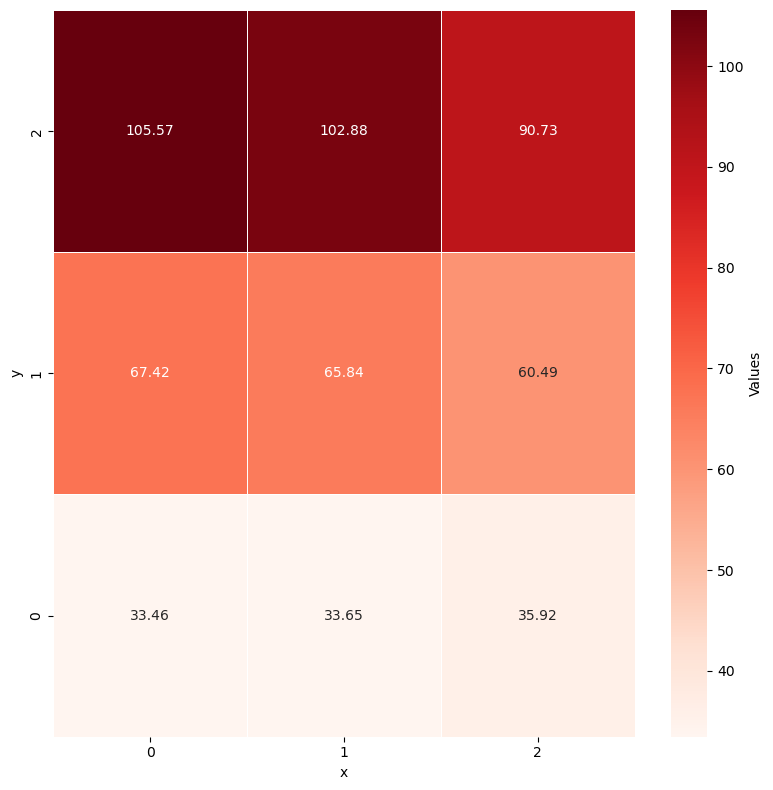

In [7]:
p291_solutions = p291_iterations_1.loc[len(p291_iterations_1)-1,unknowns]
p291_solution_grid = p291_solutions.values.reshape(3,3).astype(float)
display_grid(p291_solution_grid)

## 29.8
With the exception of the boundary conditions, the plate in Fig. P29.8 has the exact same characteristics as the plate used in Examples 29.1 through 29.3. Simulate both the temperatures and fluxes for the plate.


In [8]:
p298_data = dict(
    upper_boundary=[0,25,50,75,100],
    right_boundary=[0,25,50,75,100],
    bottom_boundary=[None] * 5, # insulated
    left_boundary=[None]*5,     # insulated
    kp=0.49, #cal/(s cm C)
    rel_error=1, #%
    dx=10,
)

In [9]:
p298_grid_t = np.zeros((5, 5)).tolist()
p298_grid_t[0][0] = p298_grid_t[4][0] = p298_grid_t[0][4] = ''
p298_grid_t[4][4] = 100

for i,j in product(range(1,5-1), repeat=2):
    p298_grid_t[i][j] = sp.symbols(f't{i}{j}')

for k in range(1,4):
    # upper boundary
    p298_grid_t[4][k] = p298_data.get('upper_boundary')[k] or p298_grid_t[2][k]
    # bottom boundary
    p298_grid_t[0][k] = p298_data.get('bottom_boundary')[k] or p298_grid_t[2][k]
    # left boundary
    p298_grid_t[k][0] = p298_data.get('bottom_boundary')[k] or p298_grid_t[k][2]
    # right boundary
    p298_grid_t[k][4] = p298_data.get('upper_boundary')[k] or p298_grid_t[k][2]

print('P29.8 - Temperatures Grid layout:')
print(display_grid_str(p298_grid_t))

P29.8 - Temperatures Grid layout:
	25	50	75	100
t32	t31	t32	t33	75
t22	t21	t22	t23	50
t12	t11	t12	t13	25
	t21	t22	t23	


 Liebmann's method formula:
$$T_{i,j} = \frac{T_{i+1,j}+T_{i-1,j}+T_{i,j+1}+T_{i,j-1}}{4}$$

In [10]:
p298_eqs = pd.Series()
for i,j in product(range(1,4), repeat=2):
    p298_eqs[f't{i}{j}'] = (p298_grid_t[i+1][j] + p298_grid_t[i-1][j]+ p298_grid_t[i][j+1] + p298_grid_t[i][j-1])* sp.Rational(1,4)
    display(Math(f't_{{{i},{j}}}(t^{{old}}_{{i,j}})={sp.latex(p298_eqs[f't{i}{j}'])}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
unknowns = [str(grid_t_291[i][j]) for i,j in product(range(1,4), repeat=2)]
p298_t_old = pd.Series({k:0 for k in unknowns})
# iterations
p291_iterations= liebmann(
    t_init=p298_t_old,
    df_eqs=p298_eqs,
    lambda_r=1,
    relative_error_threshold=p298_data['rel_error'],
    max_iterations=50,
)
display(Markdown(f'p29.8 ] liebmann method with relaxation factor {1} and relative error {p298_data["rel_error"]}%:'))
display(Markdown(p291_iterations.to_markdown()))

p29.8 ] liebmann method with relaxation factor 1 and relative error 1%:

|    |     t11 |     t12 |     t13 |     t21 |     t22 |     t23 |     t31 |     t32 |     t33 |   rel_error |
|---:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|------------:|
|  0 |  0      |  0      |  0      |  0      |  0      |  0      |  0      |  0      |  0      |  100        |
|  1 |  0      |  0      |  6.25   |  0      |  0      | 12.5    |  6.25   | 12.5    | 37.5    |  100        |
|  2 |  0      |  1.5625 | 12.5    |  1.5625 |  6.25   | 23.4375 | 12.5    | 23.4375 | 43.75   |  100        |
|  3 |  1.5625 |  6.25   | 18.3594 |  6.25   | 12.5    | 28.125  | 18.3594 | 28.125  | 49.2188 |  100        |
|  4 |  6.25   | 11.2305 | 21.875  | 11.2305 | 17.1875 | 32.5195 | 21.875  | 32.5195 | 51.5625 |  300        |
|  5 | 11.2305 | 15.625  | 25.3174 | 15.625  | 21.875  | 35.1562 | 25.3174 | 35.1562 | 53.7598 |   79.688    |
|  6 | 15.625  | 20.0745 | 27.7344 | 20.0745 | 25.3906 | 37.738  | 27.7344 | 37.738  | 55.0781 |   39.13     |
|  7 | 20.0745 | 23.5352 | 30.1376 | 23.5352 | 28.9062 | 39.5508 | 30.1376 | 39.5508 | 56.369  |   28.477    |
|  8 | 23.5352 | 27.0061 | 31.9092 | 27.0061 | 31.543  | 41.3532 | 31.9092 | 41.3532 | 57.2754 |   17.239    |
|  9 | 27.0061 | 29.6326 | 33.6782 | 29.6326 | 34.1797 | 42.6819 | 33.6782 | 42.6819 | 58.1766 |   14.748    |
| 10 | 29.6326 | 32.2609 | 34.9991 | 32.2609 | 36.1572 | 44.0086 | 34.9991 | 44.0086 | 58.8409 |    9.72498  |
| 11 | 32.2609 | 34.2365 | 36.3195 | 34.2365 | 38.1348 | 44.9993 | 36.3195 | 44.9993 | 59.5043 |    8.87     |
| 12 | 34.2365 | 36.2125 | 37.3088 | 36.2125 | 39.6179 | 45.9897 | 37.3088 | 45.9897 | 59.9997 |    6.12402  |
| 13 | 36.2125 | 37.6953 | 38.298  | 37.6953 | 41.1011 | 46.7316 | 38.298  | 46.7316 | 60.4948 |    5.77197  |
| 14 | 37.6953 | 39.1781 | 39.0396 | 39.1781 | 42.2134 | 47.4735 | 39.0396 | 47.4735 | 60.8658 |    4.09497  |
| 15 | 39.1781 | 40.2904 | 39.7813 | 40.2904 | 43.3258 | 48.0297 | 39.7813 | 48.0297 | 61.2367 |    3.93399  |
| 16 | 40.2904 | 41.4028 | 40.3375 | 41.4028 | 44.1601 | 48.586  | 40.3375 | 48.586  | 61.5149 |    2.83899  |
| 17 | 41.4028 | 42.237  | 40.8937 | 42.237  | 44.9944 | 49.0031 | 40.8937 | 49.0031 | 61.793  |    2.76099  |
| 18 | 42.237  | 43.0713 | 41.3108 | 43.0713 | 45.6201 | 49.4202 | 41.3108 | 49.4202 | 62.0016 |    2.01501  |
| 19 | 43.0713 | 43.697  | 41.7279 | 43.697  | 46.2458 | 49.7331 | 41.7279 | 49.7331 | 62.2101 |    1.97501  |
| 20 | 43.697  | 44.3227 | 42.0408 | 44.3227 | 46.715  | 50.046  | 42.0408 | 50.046  | 62.3666 |    1.453    |
| 21 | 44.3227 | 44.792  | 42.3537 | 44.792  | 47.1843 | 50.2806 | 42.3537 | 50.2806 | 62.523  |    1.43201  |
| 22 | 44.792  | 45.2612 | 42.5883 | 45.2612 | 47.5363 | 50.5152 | 42.5883 | 50.5152 | 62.6403 |    1.05901  |
| 23 | 45.2612 | 45.6132 | 42.8229 | 45.6132 | 47.8882 | 50.6912 | 42.8229 | 50.6912 | 62.7576 |    1.048    |
| 24 | 45.6132 | 45.9652 | 42.9989 | 45.9652 | 48.1522 | 50.8672 | 42.9989 | 50.8672 | 62.8456 |    0.777954 |

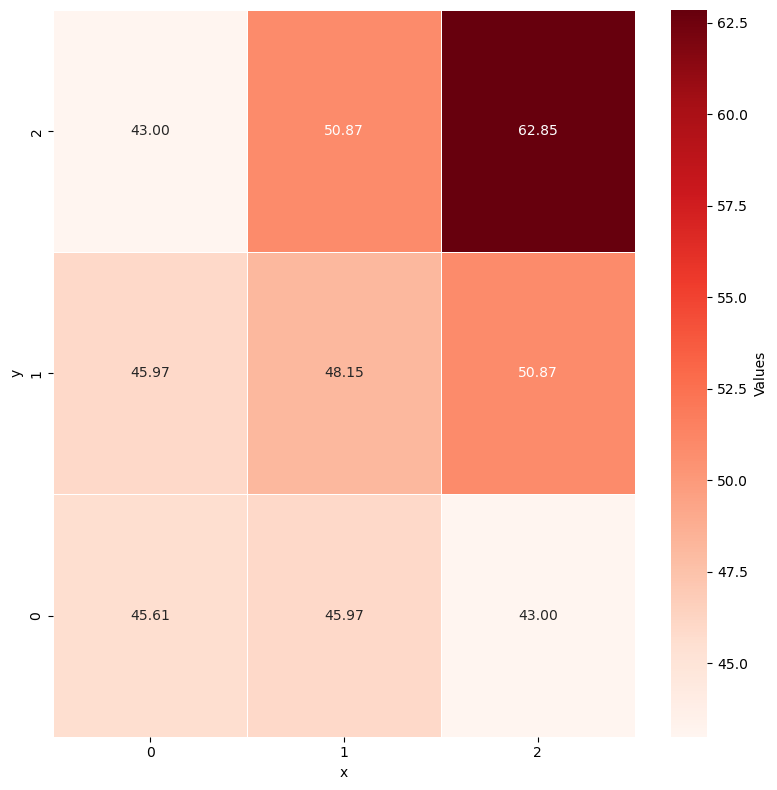

In [12]:
p298_grid1_ss = p291_iterations.loc[len(p291_iterations)-1,unknowns] # Heat steady state
p298_grid1 = p298_grid1_ss.values.reshape(3,3).astype(float)
display_grid(p298_grid1)

Heat flux

$$ q_x = -k' \frac{T_{i+1,j}-T_{i-1,j}}{1 \Delta x} $$
$$ q_y = -k' \frac{T_{i,j+1}-T_{i,j-1}}{1 \Delta y} $$
$$ q = \sqrt{q_x^2+q_y^2} $$
$$ \theta = \begin{cases}
  \tan^{-1}(\frac{q_y}{q_x}) & \text{, if } q_x\leq0 \\
  \tan^{-1}(\frac{q_y}{q_x})+\pi & \text{, if } q_x<0 \\
\end{cases}
$$

In [13]:
p298_heat_flux = heat_flux_2d(
    grid=p298_grid1,
    kp=p298_data['kp'],
    dx=p298_data['dx'],
    upper_boundary=p298_data['upper_boundary'],
    left_boundary=p298_data['left_boundary'],
    right_boundary=p298_data['right_boundary'],
    bottom_boundary=p298_data['bottom_boundary'],
)

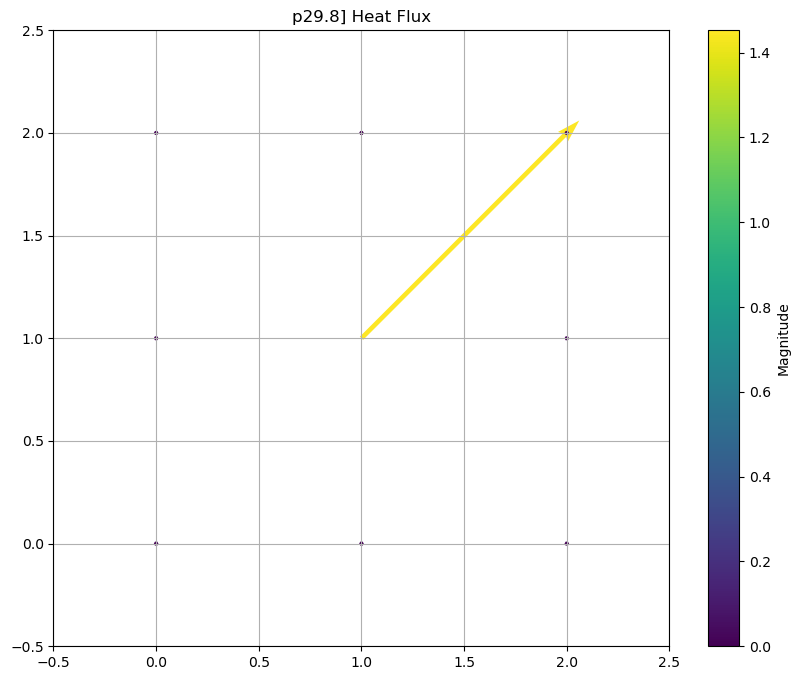

In [14]:
plot_vector_field(
    p298_heat_flux['qx'],
    p298_heat_flux['qy'],
    title='p29.8] Heat Flux',
)
plt.show()

In [15]:
p291_heat_flux = heat_flux_2d(
    grid=p291_solution_grid,
    kp=p298_data['kp'],
    dx=p298_data['dx'],
    upper_boundary=[p29_1_data.get('upper_boundary')]*3,
    left_boundary=[p29_1_data.get('left_boundary')]*3,
    right_boundary=[p29_1_data.get('right_boundary')]*3,
    bottom_boundary=[p29_1_data.get('bottom_boundary')]*3,
)

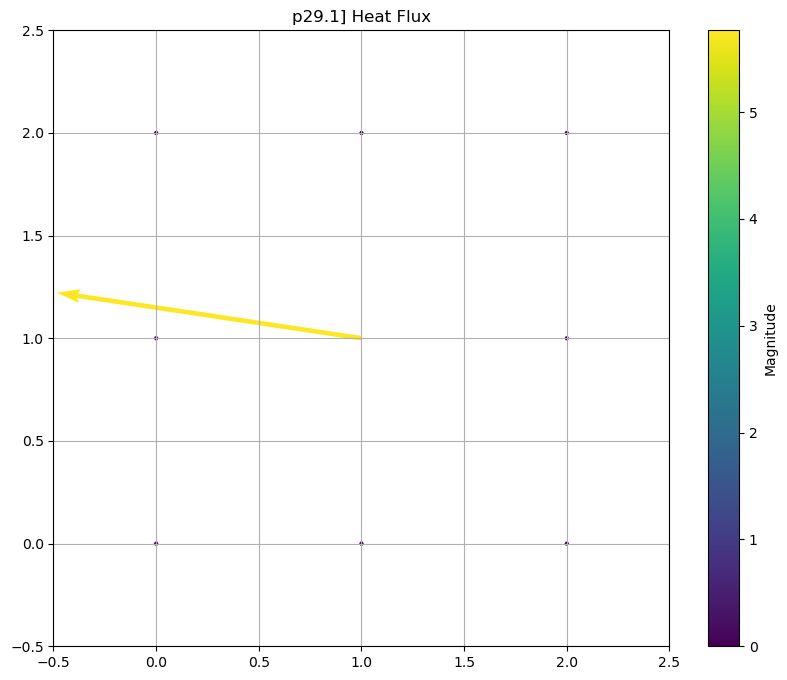

In [16]:
plot_vector_field(
    p291_heat_flux['qx'],
    p291_heat_flux['qy'],
    title='p29.1] Heat Flux',
)
plt.show()

The boundary condition have effect on the heat flux where on 29.1 plate the constant fix heat boundary create heat flow to the isolated boundary. Whereas, in 29.8 plate the fix boundary have ascending heat which makes the heat flux draws to the direction of the constant increase of temperature.